Step 1 탐색 : 시간 정보가 포함된 데이터 살펴보기

In [1]:
# -*- coing : utf-8 -*-
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
file = '../data/market-price.csv'
# names = [''] : 이름 변경
bitcoin = pd.read_csv(file, names = ['day', 'price'])
print(bitcoin.shape)
print(bitcoin.info())
bitcoin.tail()

(365, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   day     365 non-null    object 
 1   price   365 non-null    float64
dtypes: float64(1), object(1)
memory usage: 5.8+ KB
None


,day,price
360,2018-08-22 00:00:00,6575.229167
361,2018-08-23 00:00:00,6434.881667
362,2018-08-24 00:00:00,6543.645714
363,2018-08-25 00:00:00,6719.429231
364,2018-08-26 00:00:00,6673.274167


In [3]:
bitcoin['day'] = pd.to_datetime(bitcoin['day'])

bitcoin.index = bitcoin['day']
bitcoin.set_index('day', inplace = True)

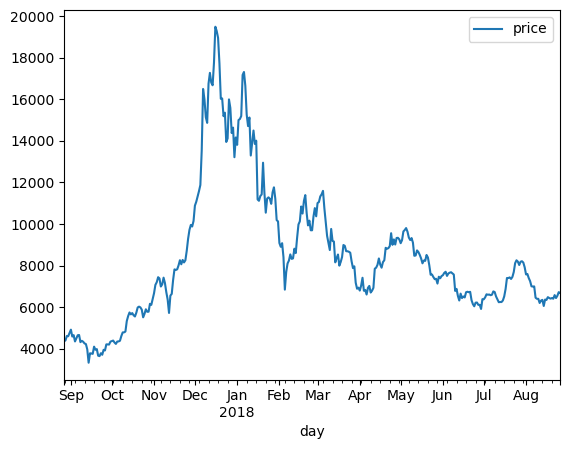

In [4]:
bitcoin.plot()
plt.show()

Step 2 예측 : 파이썬 라이브러리를 활용해 시세 예측하기

In [5]:
# statsmodels.tsa.arima_model.ARIMA -> statsmodels.tsa.arima.model.ARIMA and statsmodels.tsa.SARIMAX.
from statsmodels.tsa.arima.model import ARIMA 
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_predict

In [6]:
# order = (AR = 2, 차분 = 1, MA = 2)
model = ARIMA(bitcoin.price.values, order = (2, 1, 2))
model_fit = model.fit()
print(model_fit.summary())

C:\Users\yelin\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\yelin\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  365
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -2787.490
Date:                Wed, 26 Apr 2023   AIC                           5584.980
Time:                        19:17:47   BIC                           5604.466
Sample:                             0   HQIC                          5592.725
                                - 365                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2418      0.305      0.793      0.428      -0.356       0.839
ar.L2          0.6071      0.200      3.036      0.002       0.215       0.999
ma.L1         -0.1513      0.306     -0.494      0.6

<AxesSubplot:>

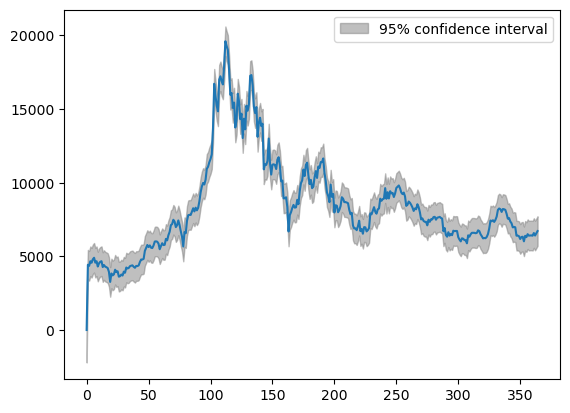

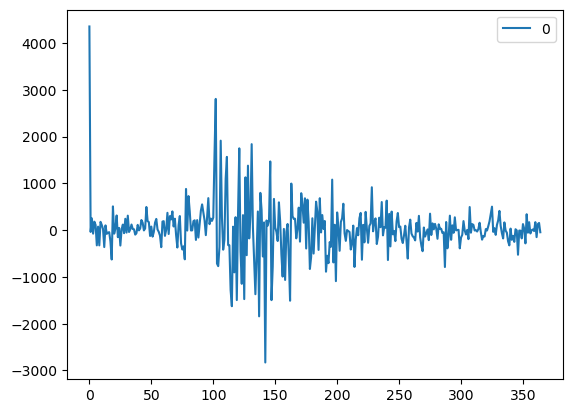

In [7]:
# fig = model_fit.plot_predict() -> plot_predict(model_fit)
plot_predict(model_fit)  # 학습 데이터 예측 결과
residuals = pd.DataFrame(model_fit.resid)  # 잔차의 변동 시각화
residuals.plot()

모델 평가

In [8]:
forecast_data = model_fit.forecast(steps = 5)  # 5일 뒤 예측
forecast_data

array([6672.47260572, 6674.47233552, 6674.46923615, 6675.68257057,
       6675.97408092])

In [9]:
test_file = '../data/market-price-test.csv'
bitcoin_test = pd.read_csv(test_file, names = ['ds', 'y'])

pred_y = forecast_data.tolist()  # 마지막 5일에 대한 예측 데이터 (2018-08-27 ~ 2018-08-31)
test_y = bitcoin_test.y.values  # 실제 5일 가격 데이터 (2018-08-27 ~ 2018-08-31)

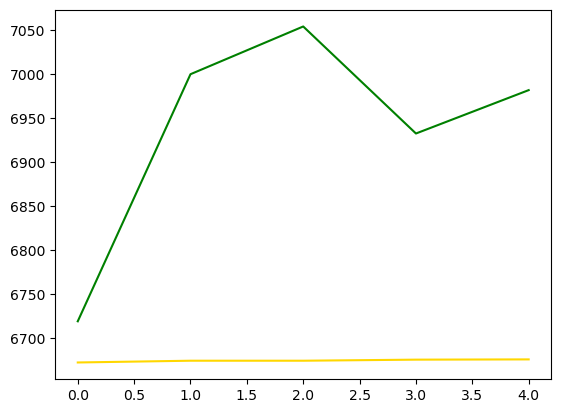

In [10]:
# 상한가, 하한가 제외
plt.plot(pred_y, color = 'gold')
plt.plot(test_y, color = 'green')
plt.show()

In [11]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rmse = np.sqrt(mean_squared_error(pred_y, test_y))
print(rmse)

287.0871077759778


Prophet 라이브러리

In [12]:
from prophet import Prophet

# prophet을 사용하기 위해서는 'ds', 'y'로 변경해야 함
bitcoin = pd.read_csv(file, names = ['ds', 'y'])

prophet = Prophet(seasonality_mode = 'multiplicative',
                 yearly_seasonality = True,
                 weekly_seasonality = True, 
                 daily_seasonality = True,
                 changepoint_prior_scale = 0.5)

prophet.fit(bitcoin)

C:\Users\yelin\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


In [13]:
future_data = prophet.make_future_dataframe(periods = 5, freq = 'd')
forecast_data = prophet.predict(future_data)
forecast_data[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(5)

C:\Users\yelin\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\yelin\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


,ds,yhat,yhat_lower,yhat_upper
365,2018-08-27,6899.724550,6283.883598,7603.615074
366,2018-08-28,6990.060163,6266.029206,7650.916657
367,2018-08-29,7001.125569,6347.098453,7716.831493
368,2018-08-30,7070.236574,6370.881982,7803.980863
369,2018-08-31,7138.333532,6454.448743,7890.051991


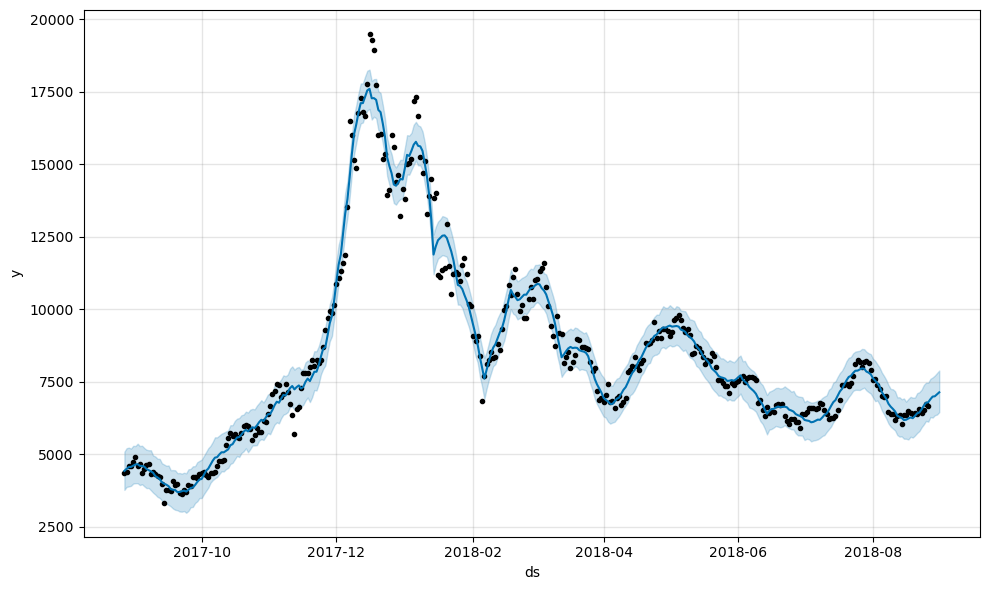

In [14]:
fig1 = prophet.plot(forecast_data)

C:\Users\yelin\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\yelin\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\yelin\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


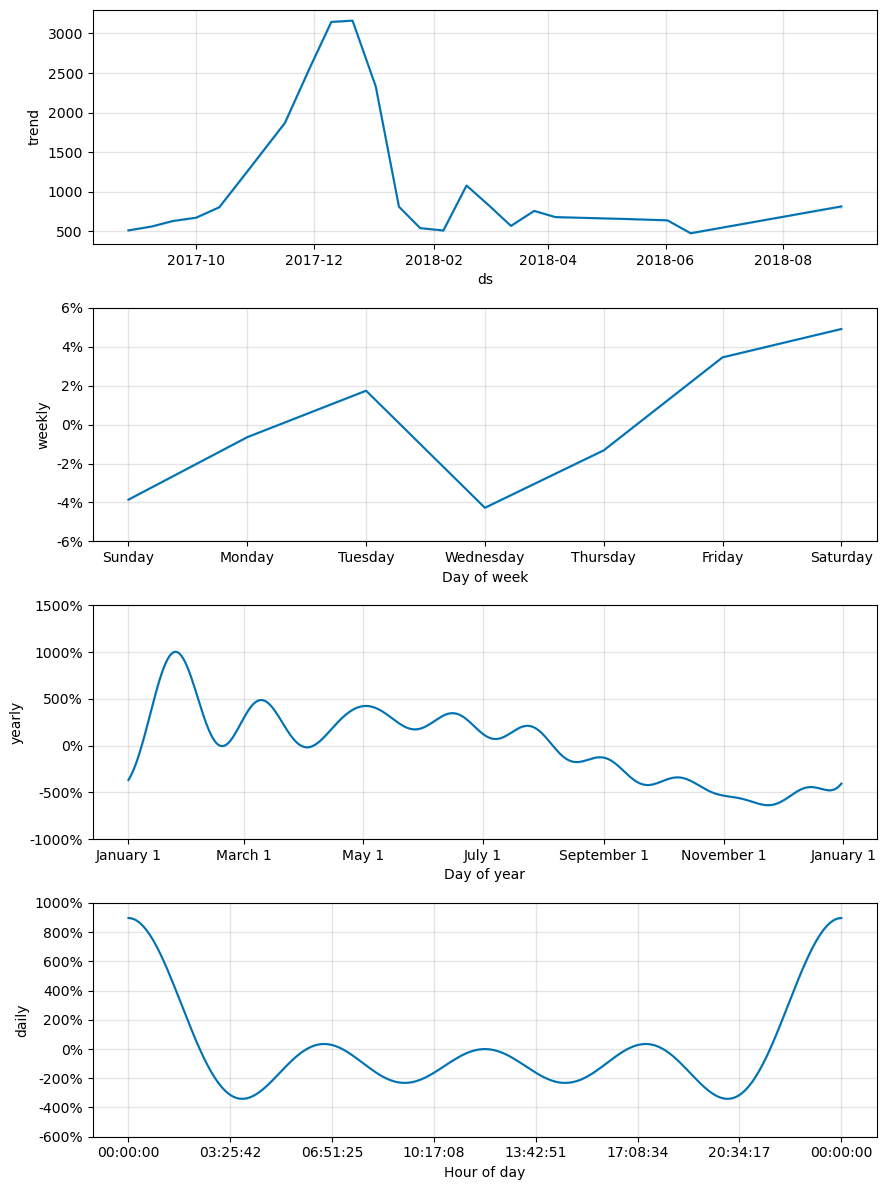

In [15]:
fig2 = prophet.plot_components(forecast_data)

테스트 데이터셋 평가

In [18]:
test_file = '../data/market-price-test.csv'
bitcoin_test = pd.read_csv(test_file, names = ['ds', 'y'])

pred_y = forecast_data.yhat.values[-5:]
test_y = bitcoin_test.y.values

pred_y_lower = forecast_data.yhat_lower.values[-5:]
pred_y_upper = forecast_data.yhat_upper.values[-5:]

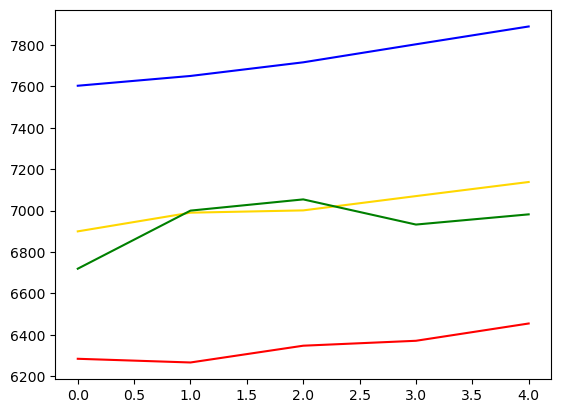

In [19]:
plt.plot(pred_y, color = 'gold')
plt.plot(pred_y_lower, color = 'red')
plt.plot(pred_y_upper, color = 'blue')
plt.plot(test_y, color = 'green')

In [20]:
from sklearn.metrics import mean_squared_error
from math import sqrt

In [21]:
rmse = np.sqrt(mean_squared_error(pred_y, test_y))
print(rmse)

125.59735772191783


Step 3 활용 : 더 나은 결과를 위한 방법

In [22]:
bitcoin = pd.read_csv(file, names = ['ds', 'y'])

# 상한가 설정
bitcoin['cap'] = 20000

prophet = Prophet(seasonality_mode = 'multiplicative',
                  growth = 'logistic',
                  yearly_seasonality = True,
                  weekly_seasonality = True, 
                  daily_seasonality = True,
                  changepoint_prior_scale = 0.5)

prophet.fit(bitcoin)

C:\Users\yelin\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


In [23]:
# 5일을 내다보며 예측
future_data = prophet.make_future_dataframe(periods = 5, freq = 'd')

future_data['cap'] = 20000
forecast_data = prophet.predict(future_data)

C:\Users\yelin\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\yelin\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


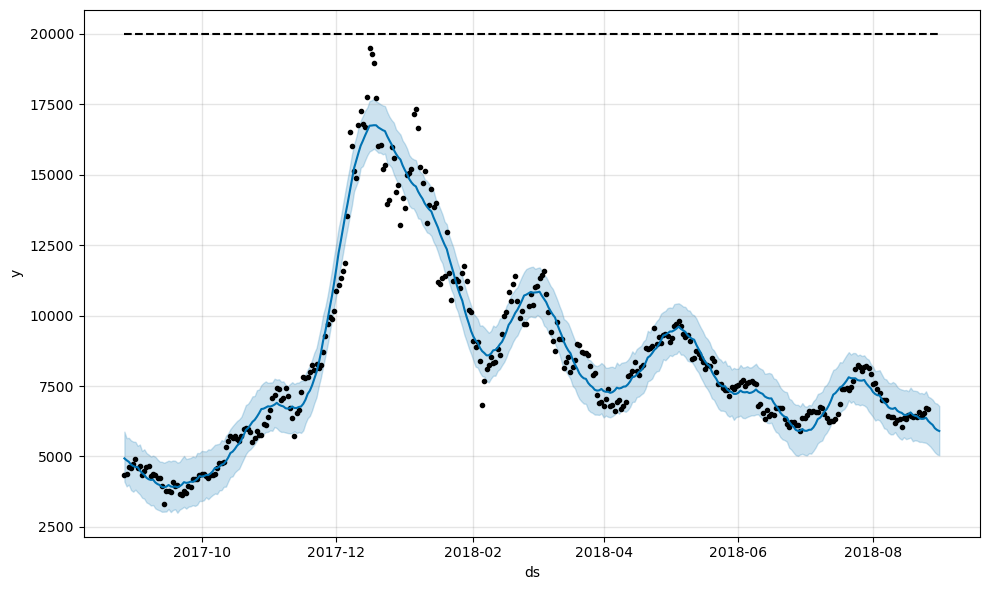

In [24]:
fig = prophet.plot(forecast_data)

In [25]:
bitcoin_test = pd.read_csv(test_file, names = ['ds', 'y'])

pred_y = forecast_data.yhat.values[-5:]
test_y = bitcoin_test.y.values

pred_y_lower = forecast_data.yhat_lower.values[-5:]
pred_y_upper = forecast_data.yhat_upper.values[-5:]

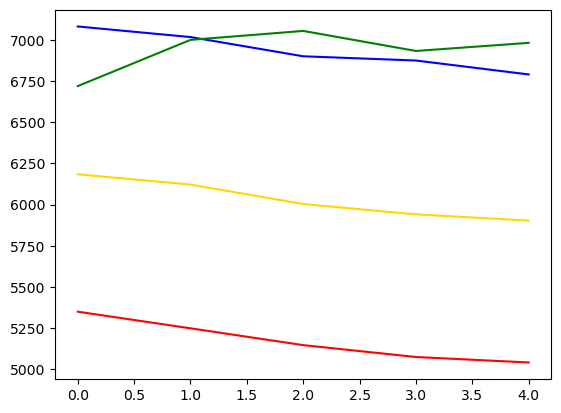

In [26]:
plt.plot(pred_y, color = 'gold')
plt.plot(pred_y_lower, color = 'red')
plt.plot(pred_y_upper, color = 'blue')
plt.plot(test_y, color = 'green')

이상치 제거 기법

In [27]:
# 18000 이상의 데이터 : 이상치로 판단
bitcoin = pd.read_csv(file, names = ['ds', 'y'])
# bitcoin['y'] > 18000 값의 'y'를 NaN으로 변경
bitcoin.loc[bitcoin['y'] > 18000, 'y'] = None

bitcoin.iloc[110:115]

,ds,y
110,2017-12-15 00:00:00,17771.900000
111,2017-12-16 00:00:00,NaN
112,2017-12-17 00:00:00,NaN
113,2017-12-18 00:00:00,NaN
114,2017-12-19 00:00:00,17737.111667


In [28]:
prophet = Prophet(seasonality_mode = 'multiplicative',
                  yearly_seasonality = True,
                  weekly_seasonality = True, 
                  daily_seasonality = True,
                  changepoint_prior_scale = 0.5)

prophet.fit(bitcoin)

C:\Users\yelin\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


In [36]:
future_data = prophet.make_future_dataframe(periods = 5, freq = 'd')
forecast_data = prophet.predict(future_data)
forecast_data[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

C:\Users\yelin\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\yelin\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


,ds,yhat,yhat_lower,yhat_upper
0,2017-08-27,4569.138990,3966.449201,5117.990678
1,2017-08-28,4623.510402,3960.423355,5225.826225
2,2017-08-29,4704.270703,4066.434611,5265.139266
3,2017-08-30,4689.610216,4087.163779,5235.561893
4,2017-08-31,4703.404506,4092.529898,5240.864091
...,...,...,...,...
365,2018-08-27,6976.102542,6403.036445,7574.862475
366,2018-08-28,7170.658542,6588.546833,7786.521132
367,2018-08-29,7222.886036,6613.039385,7852.475473
368,2018-08-30,7322.227415,6624.389156,8018.653578


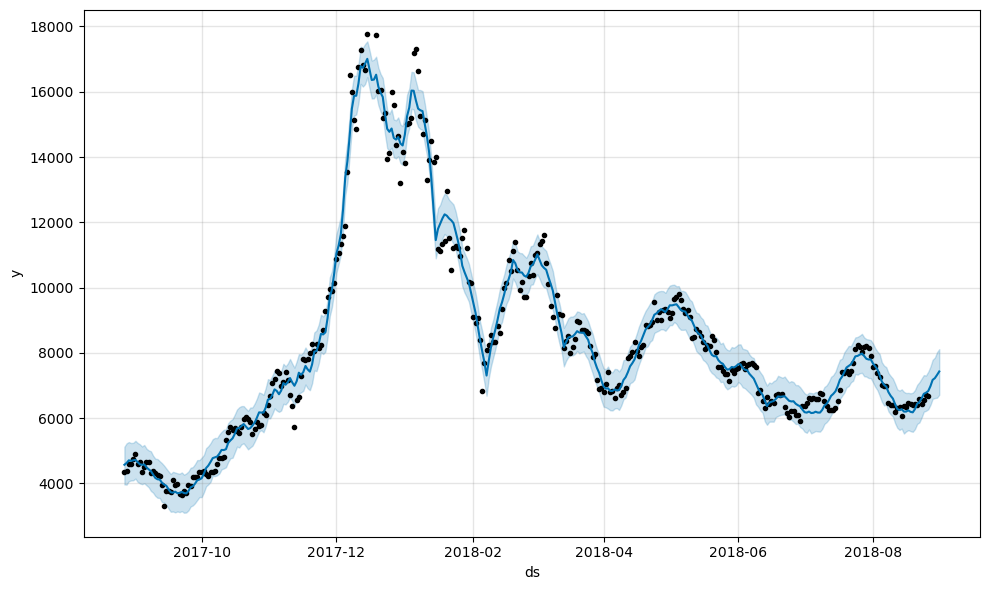

In [37]:
fig = prophet.plot(forecast_data)

In [38]:
bitcoin_test = pd.read_csv(test_file, names = ['ds', 'y'])

pred_y = forecast_data.yhat.values[-5:]
test_y = bitcoin_test.y.values

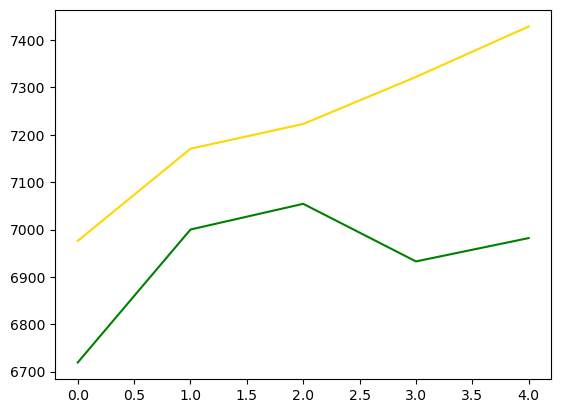

In [39]:
plt.plot(pred_y, color = 'gold')
plt.plot(test_y, color = 'green')

In [35]:
rmse = sqrt(mean_squared_error(pred_y, test_y))
print(rmse)

308.19506587310275
